# Code 1: Bayesian Inference

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy import stats
from scipy.stats import entropy
from scipy.optimize import minimize

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(521)
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

## A DIY Sampler, Do Not Try This at Home

### Figure 1.1

/tmp/ipykernel_20488/3995782036.py:5: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(prior)


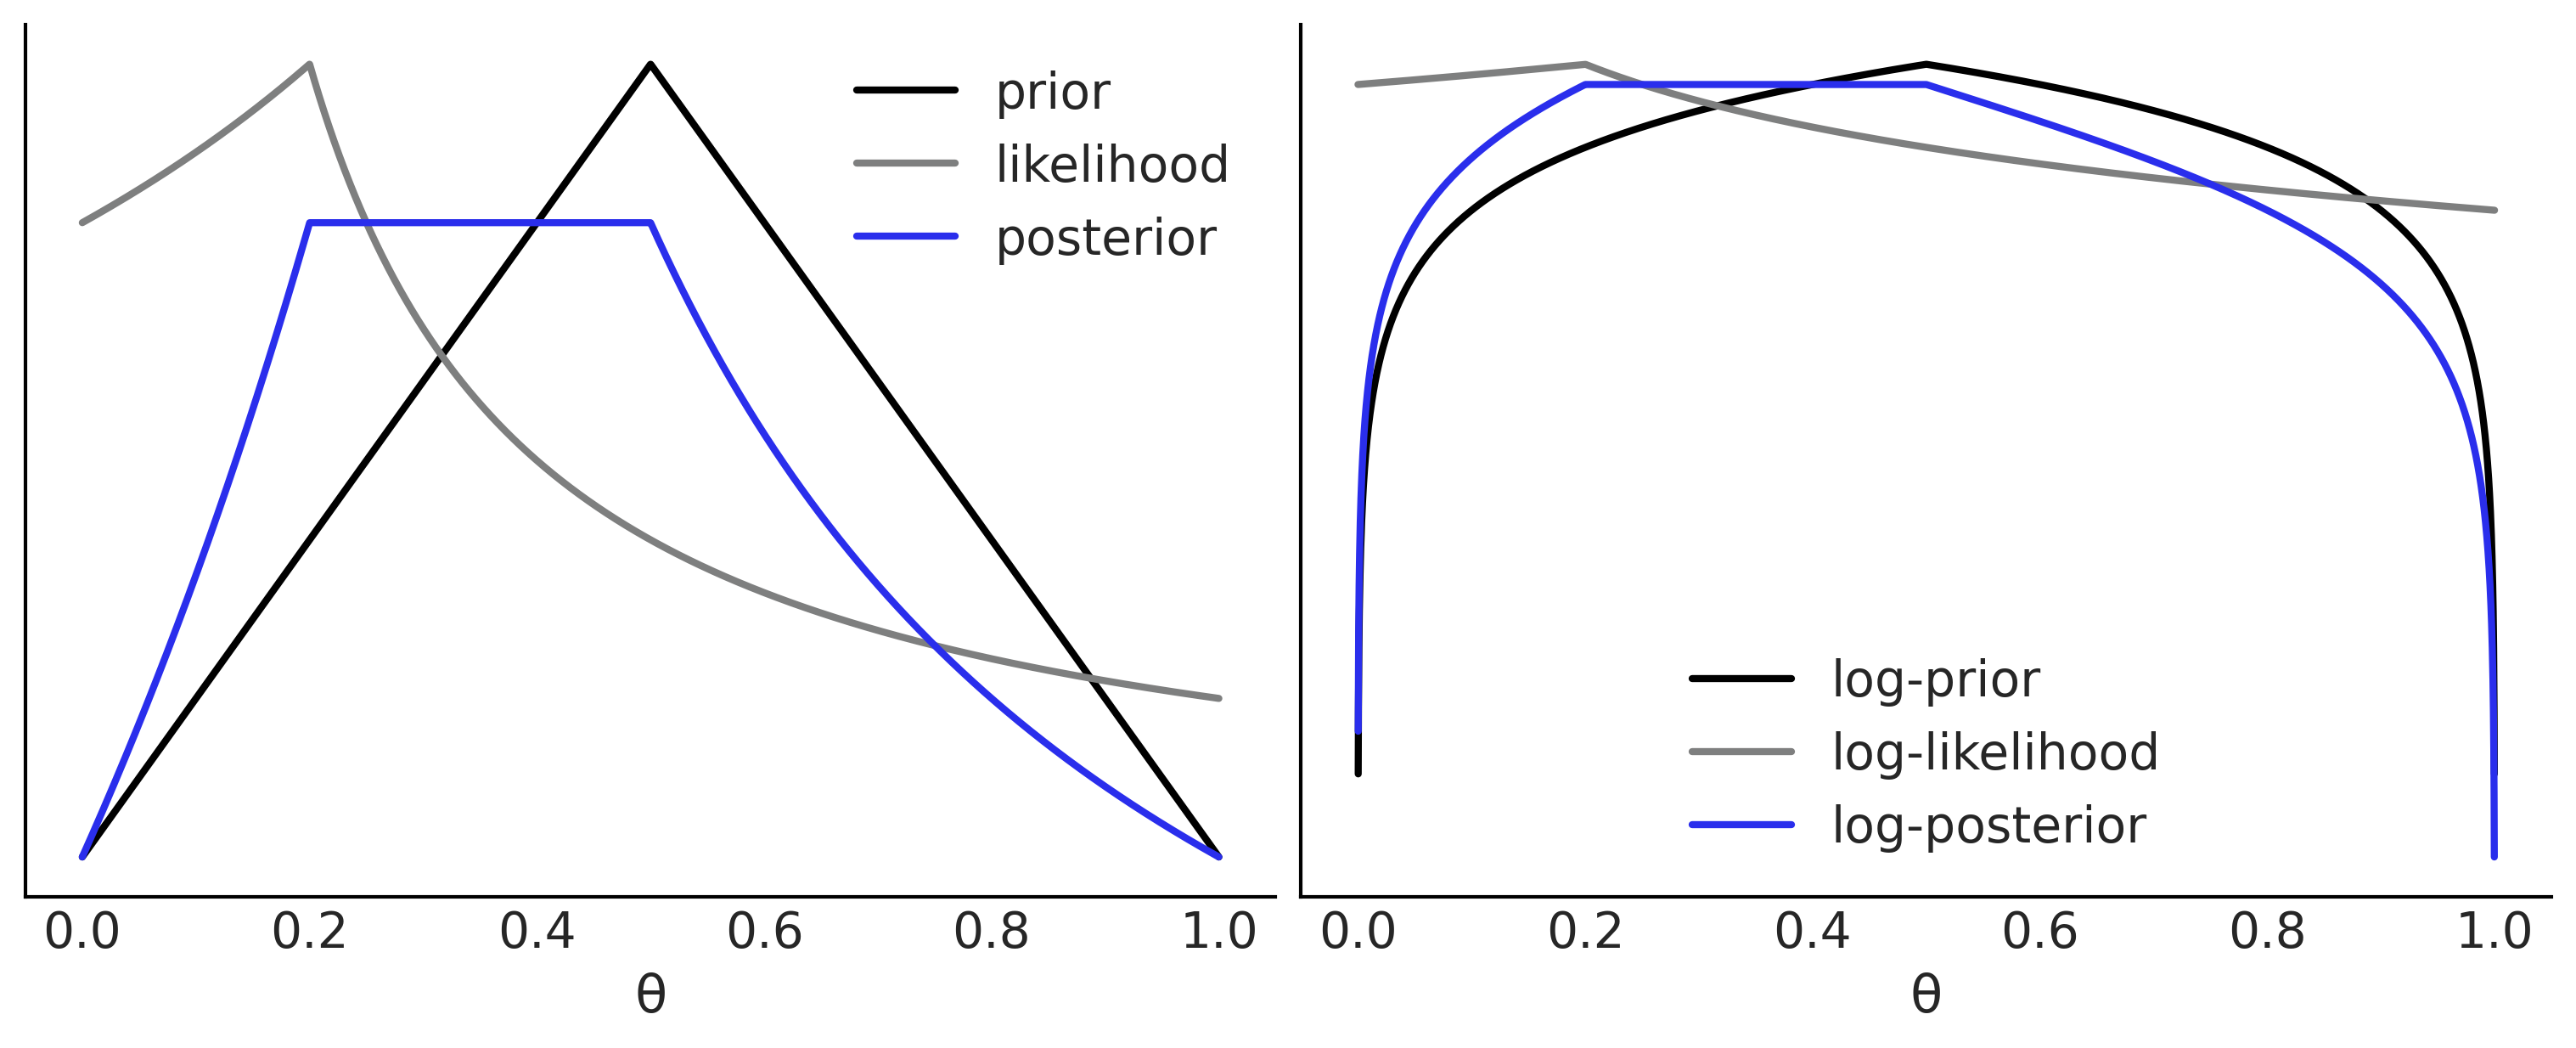

In [3]:
grid = np.linspace(0, 1, 5000)
prior = stats.triang.pdf(grid, 0.5)
likelihood = stats.triang.pdf(0.2, grid)
posterior = prior * likelihood
log_prior = np.log(prior)
log_likelihood = np.log(likelihood)
log_posterior = log_prior + log_likelihood


_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(grid, prior, label="prior", lw=2)
ax[0].plot(grid, likelihood, label="likelihood", lw=2, color="C2")
ax[0].plot(grid, posterior, label="posterior", lw=2, color="C4")
ax[0].set_xlabel("θ")
ax[0].legend()
ax[0].set_yticks([])


ax[1].plot(grid, log_prior, label="log-prior", lw=2)
ax[1].plot(grid, log_likelihood, label="log-likelihood", lw=2, color="C2")
ax[1].plot(grid, log_posterior, label="log-posterior", lw=2, color="C4")
ax[1].set_xlabel("θ")
ax[1].legend()
ax[1].set_yticks([])
plt.savefig("img/chp01/bayesian_triad.png")

### Code 1.1

In [4]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prop = like * prior
    else:
        prop = -np.inf
    return prop

### Code 1.2

In [5]:
Y = stats.bernoulli(0.7).rvs(20)

### Code 1.3

In [6]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5
trace = {'θ':np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace['θ'][iter] = θ

### Code 1.5

In [7]:
az.summary(trace, kind='stats', round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.69,0.1,0.51,0.87


### Code 1.4 and Figure 1.2

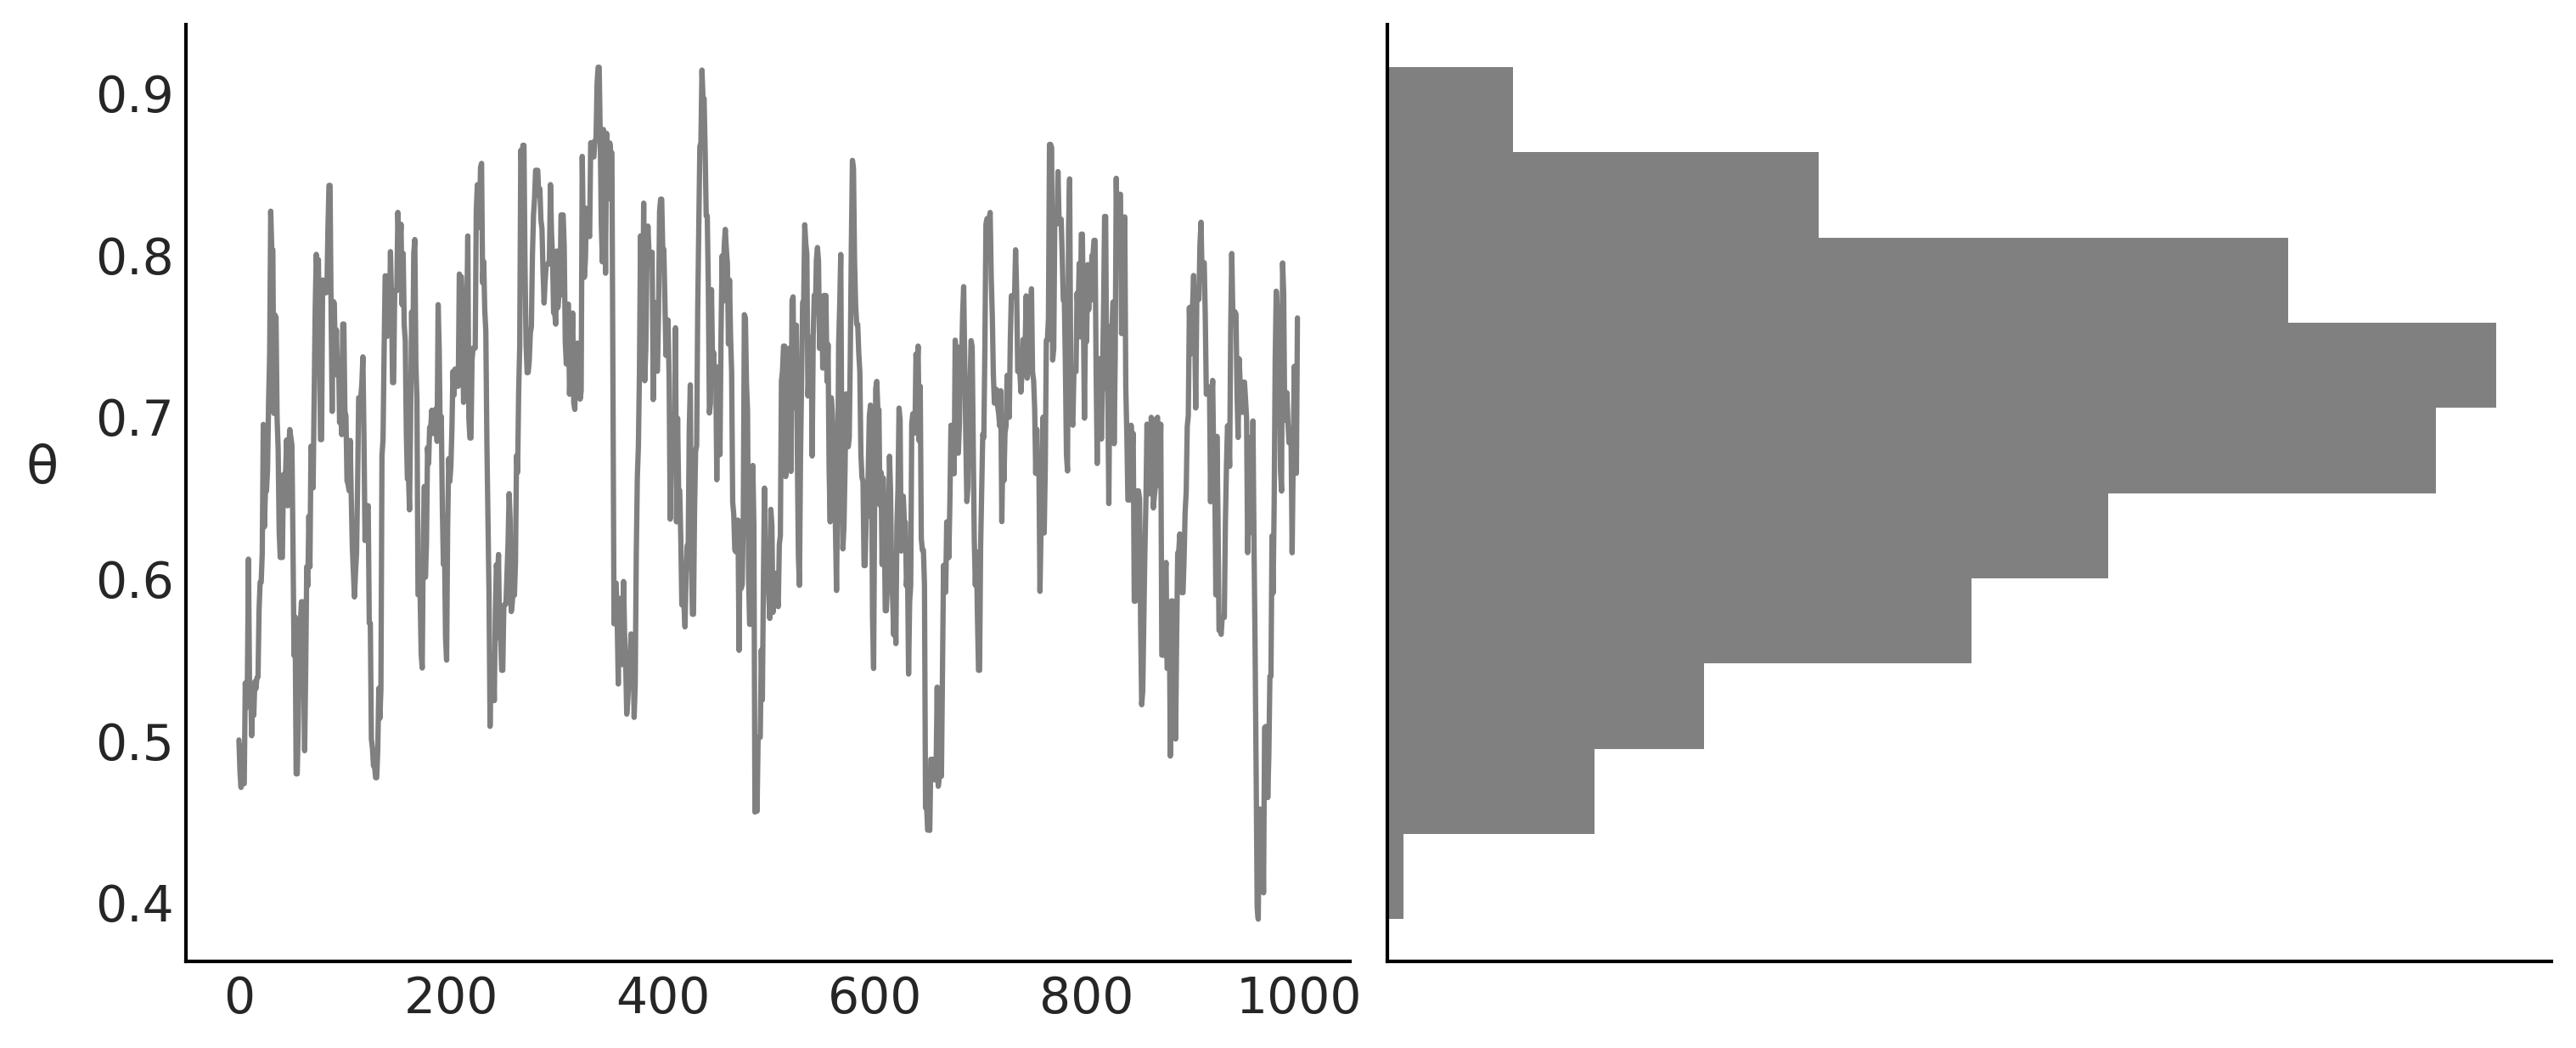

In [8]:
_, axes = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True, sharey=True)
axes[1].hist(trace['θ'], color='0.5', orientation="horizontal", density=True)
axes[1].set_xticks([])
axes[0].plot(trace['θ'], '0.5')
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
plt.savefig("img/chp01/traceplot.png")

## Say Yes to Automating Inference, Say No to Automated Model Building

### Figure 1.3

/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


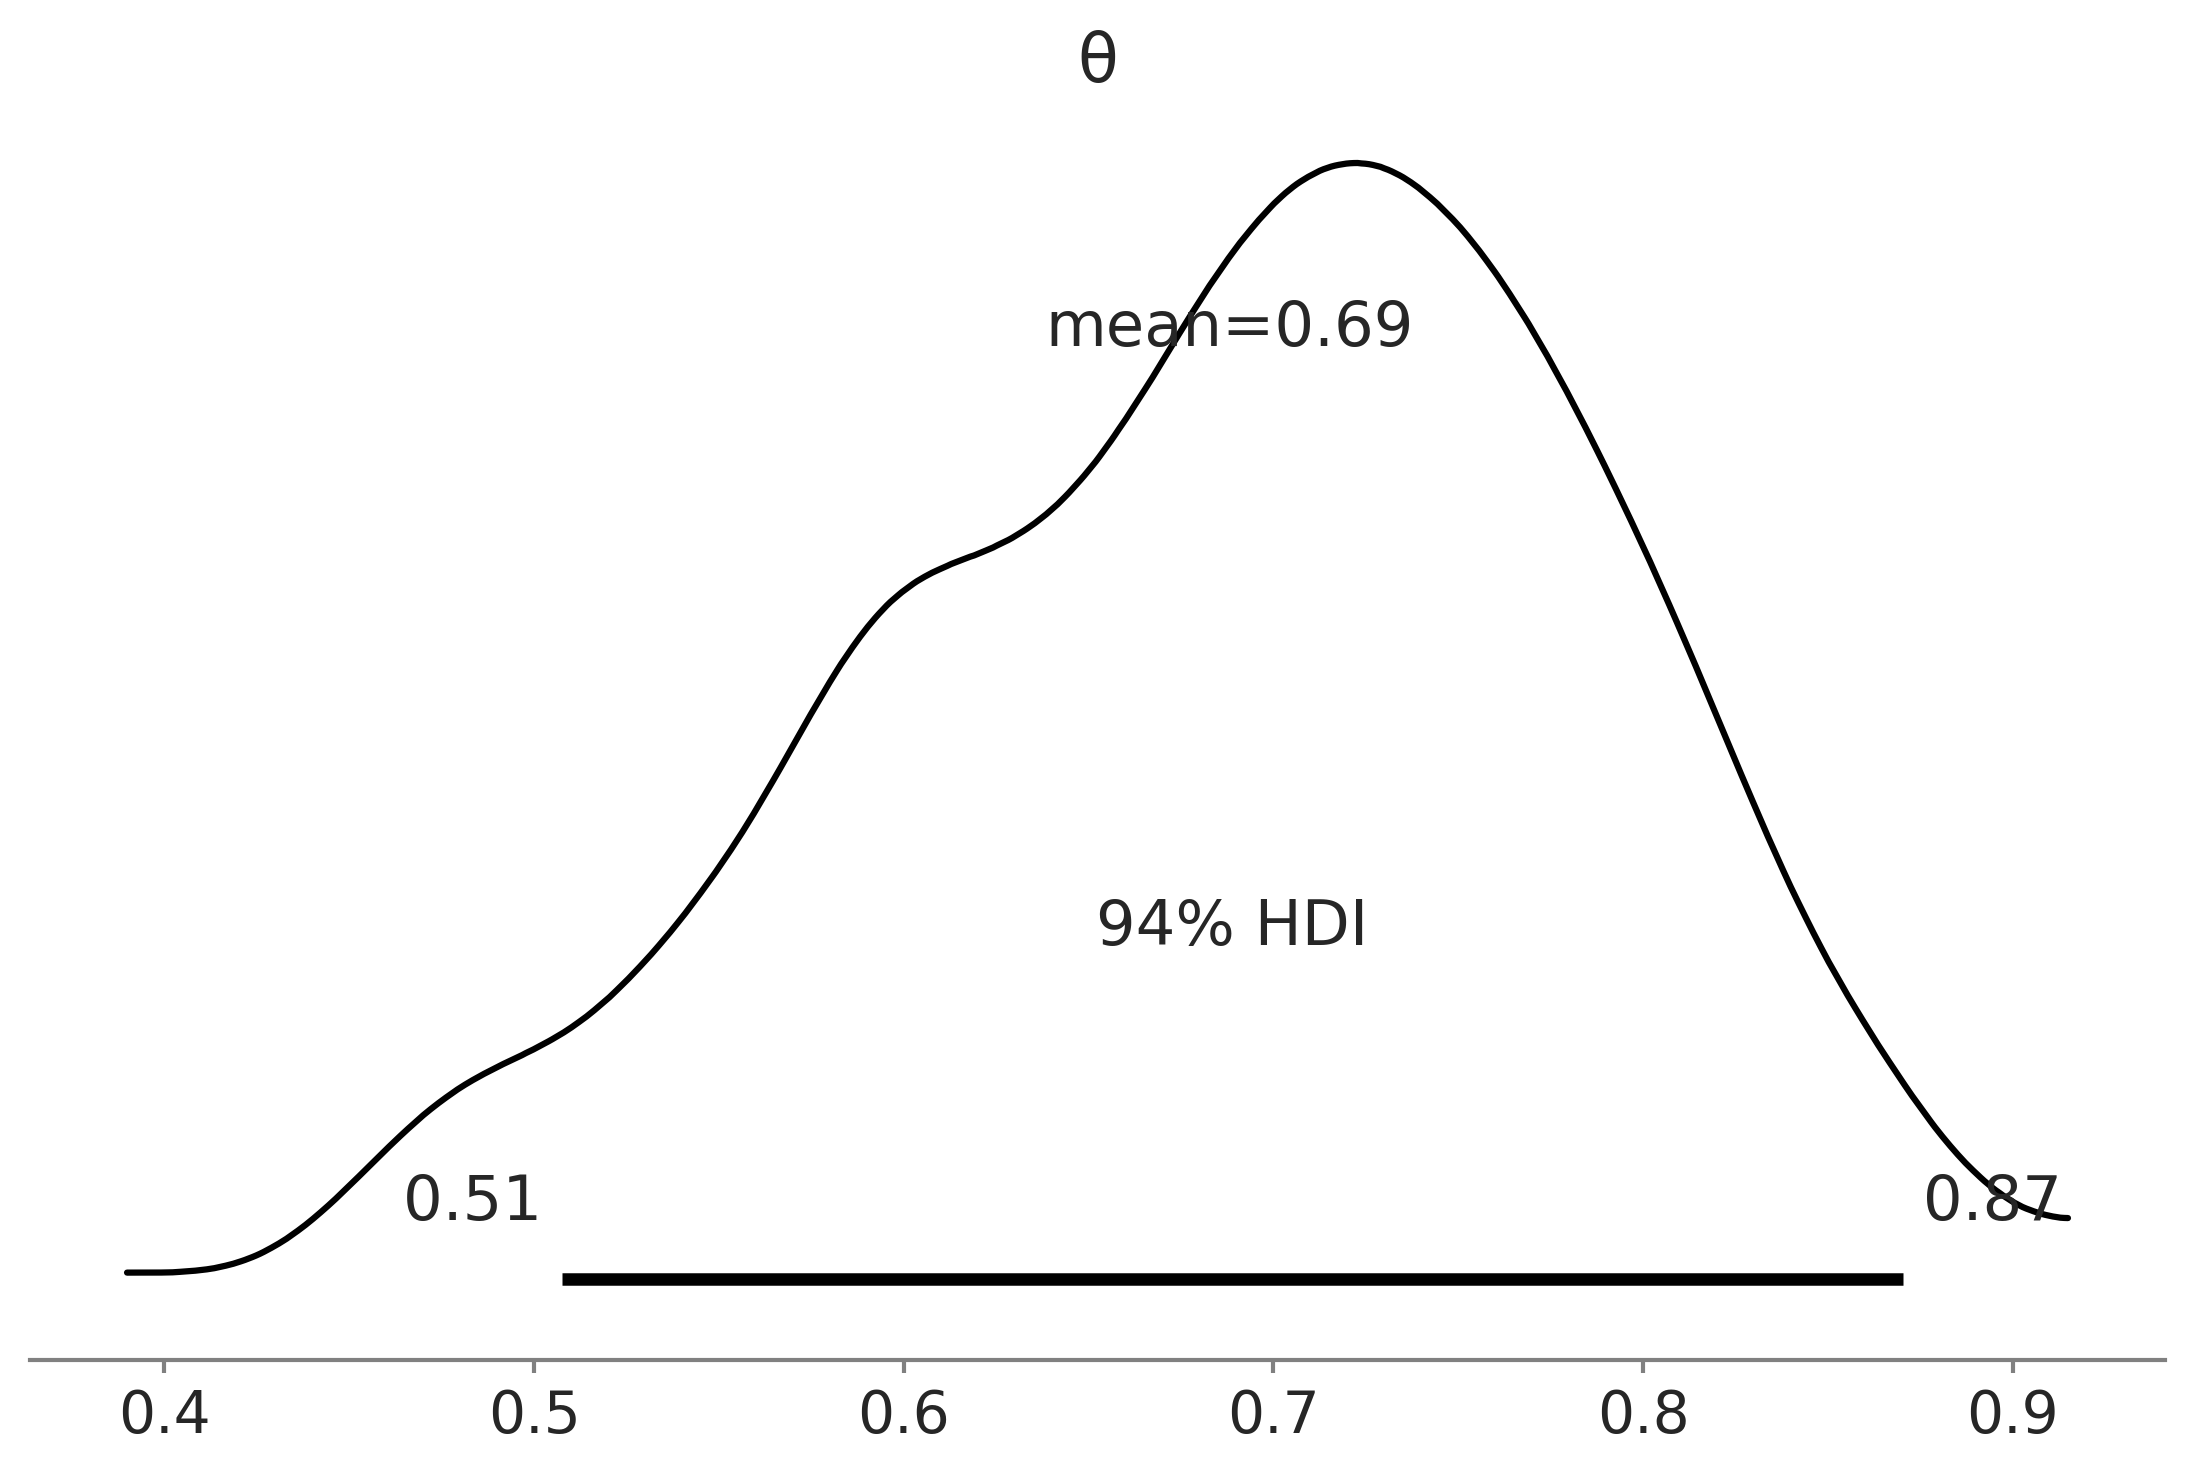

In [9]:
az.plot_posterior(trace)
plt.savefig("img/chp01/plot_posterior.png")

### Code 1.6

In [10]:
# Declare a model in PyMC3
with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    θ = pm.Beta("θ", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

    # Sample from the posterior distribution
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
/home/osvaldo/anaconda3/envs/bmcpu/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


### Code 1.7

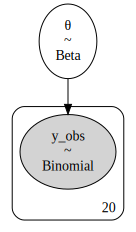

In [11]:
graphviz = pm.model_to_graphviz(model)
graphviz

In [12]:
graphviz.graph_attr.update(dpi="300")
graphviz.render("img/chp01/BetaBinomModelGraphViz", format="png")

'img/chp01/BetaBinomModelGraphViz.png'

## A Few Options to Quantify Your Prior Information

### Figure 1.5

In [13]:
pred_dists = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata, model).posterior_predictive["y_obs"].values)

Sampling: [y_obs, θ]
Sampling: [y_obs]


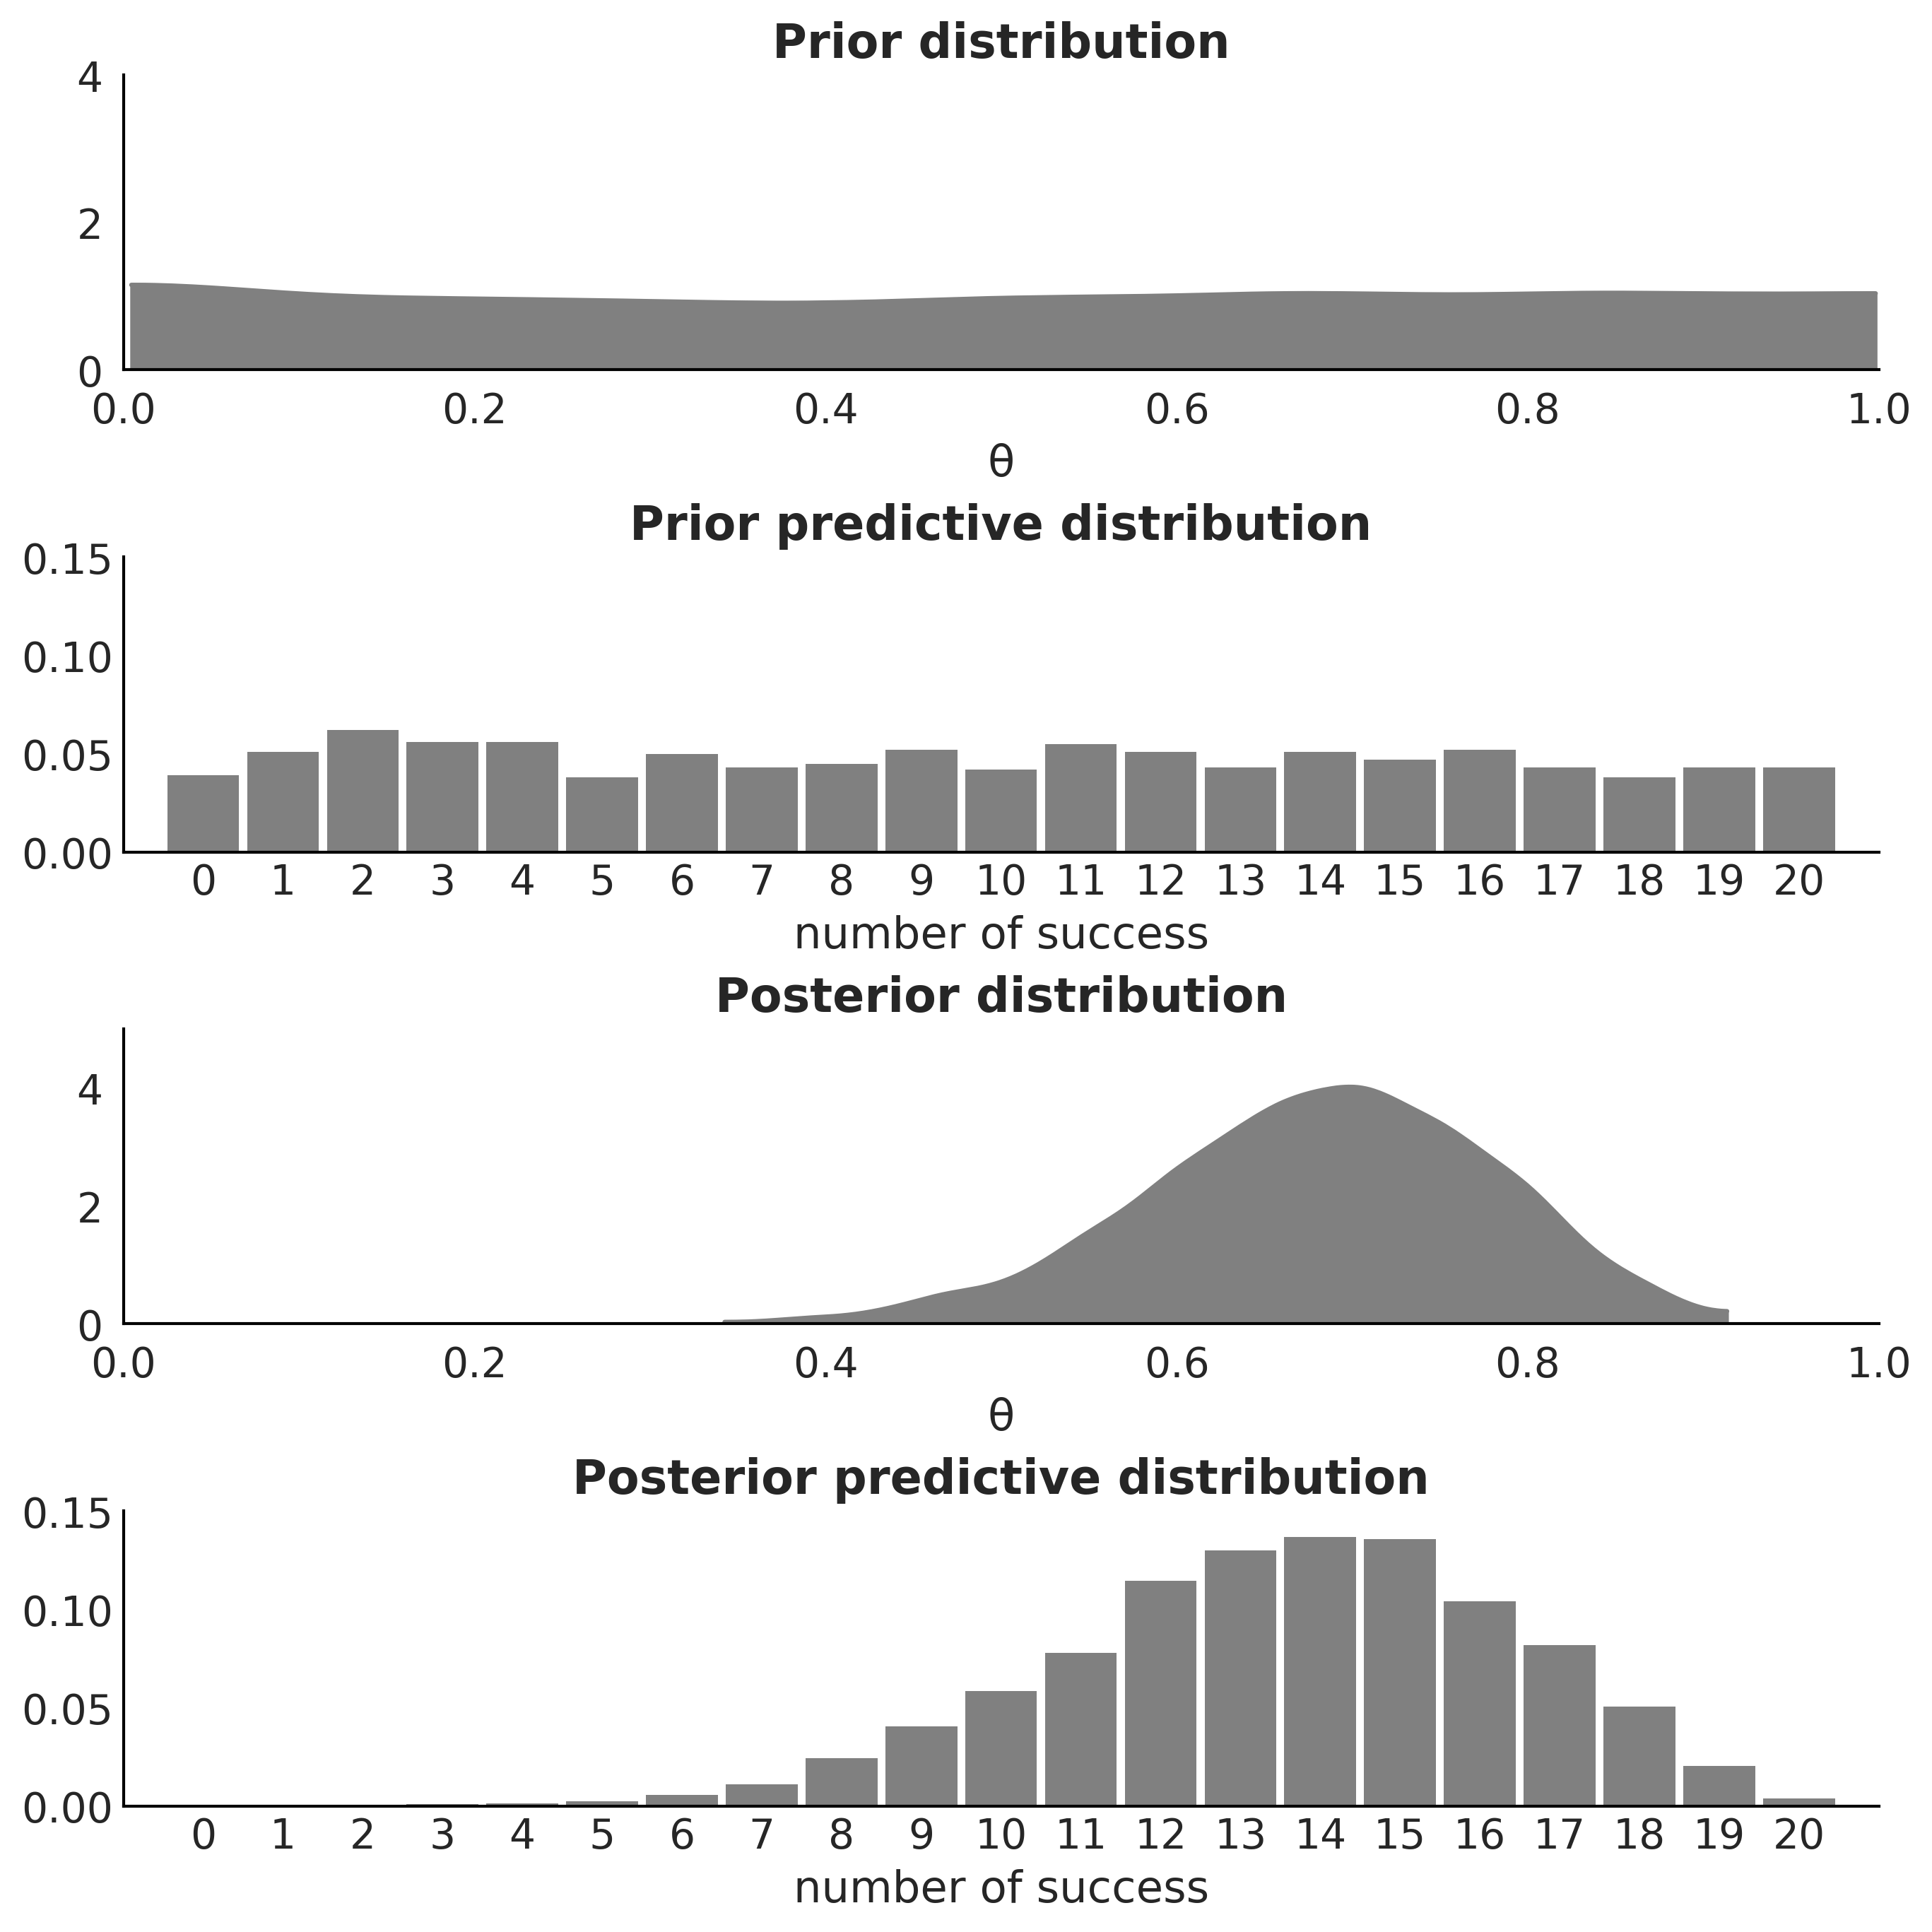

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_ylim(0, 0.15)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(θ, 1000), plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("θ")

az.plot_dist(idata.posterior["θ"], plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("θ")

plt.savefig("img/chp01/Bayesian_quartet_distributions.png")

### Figure 1.6

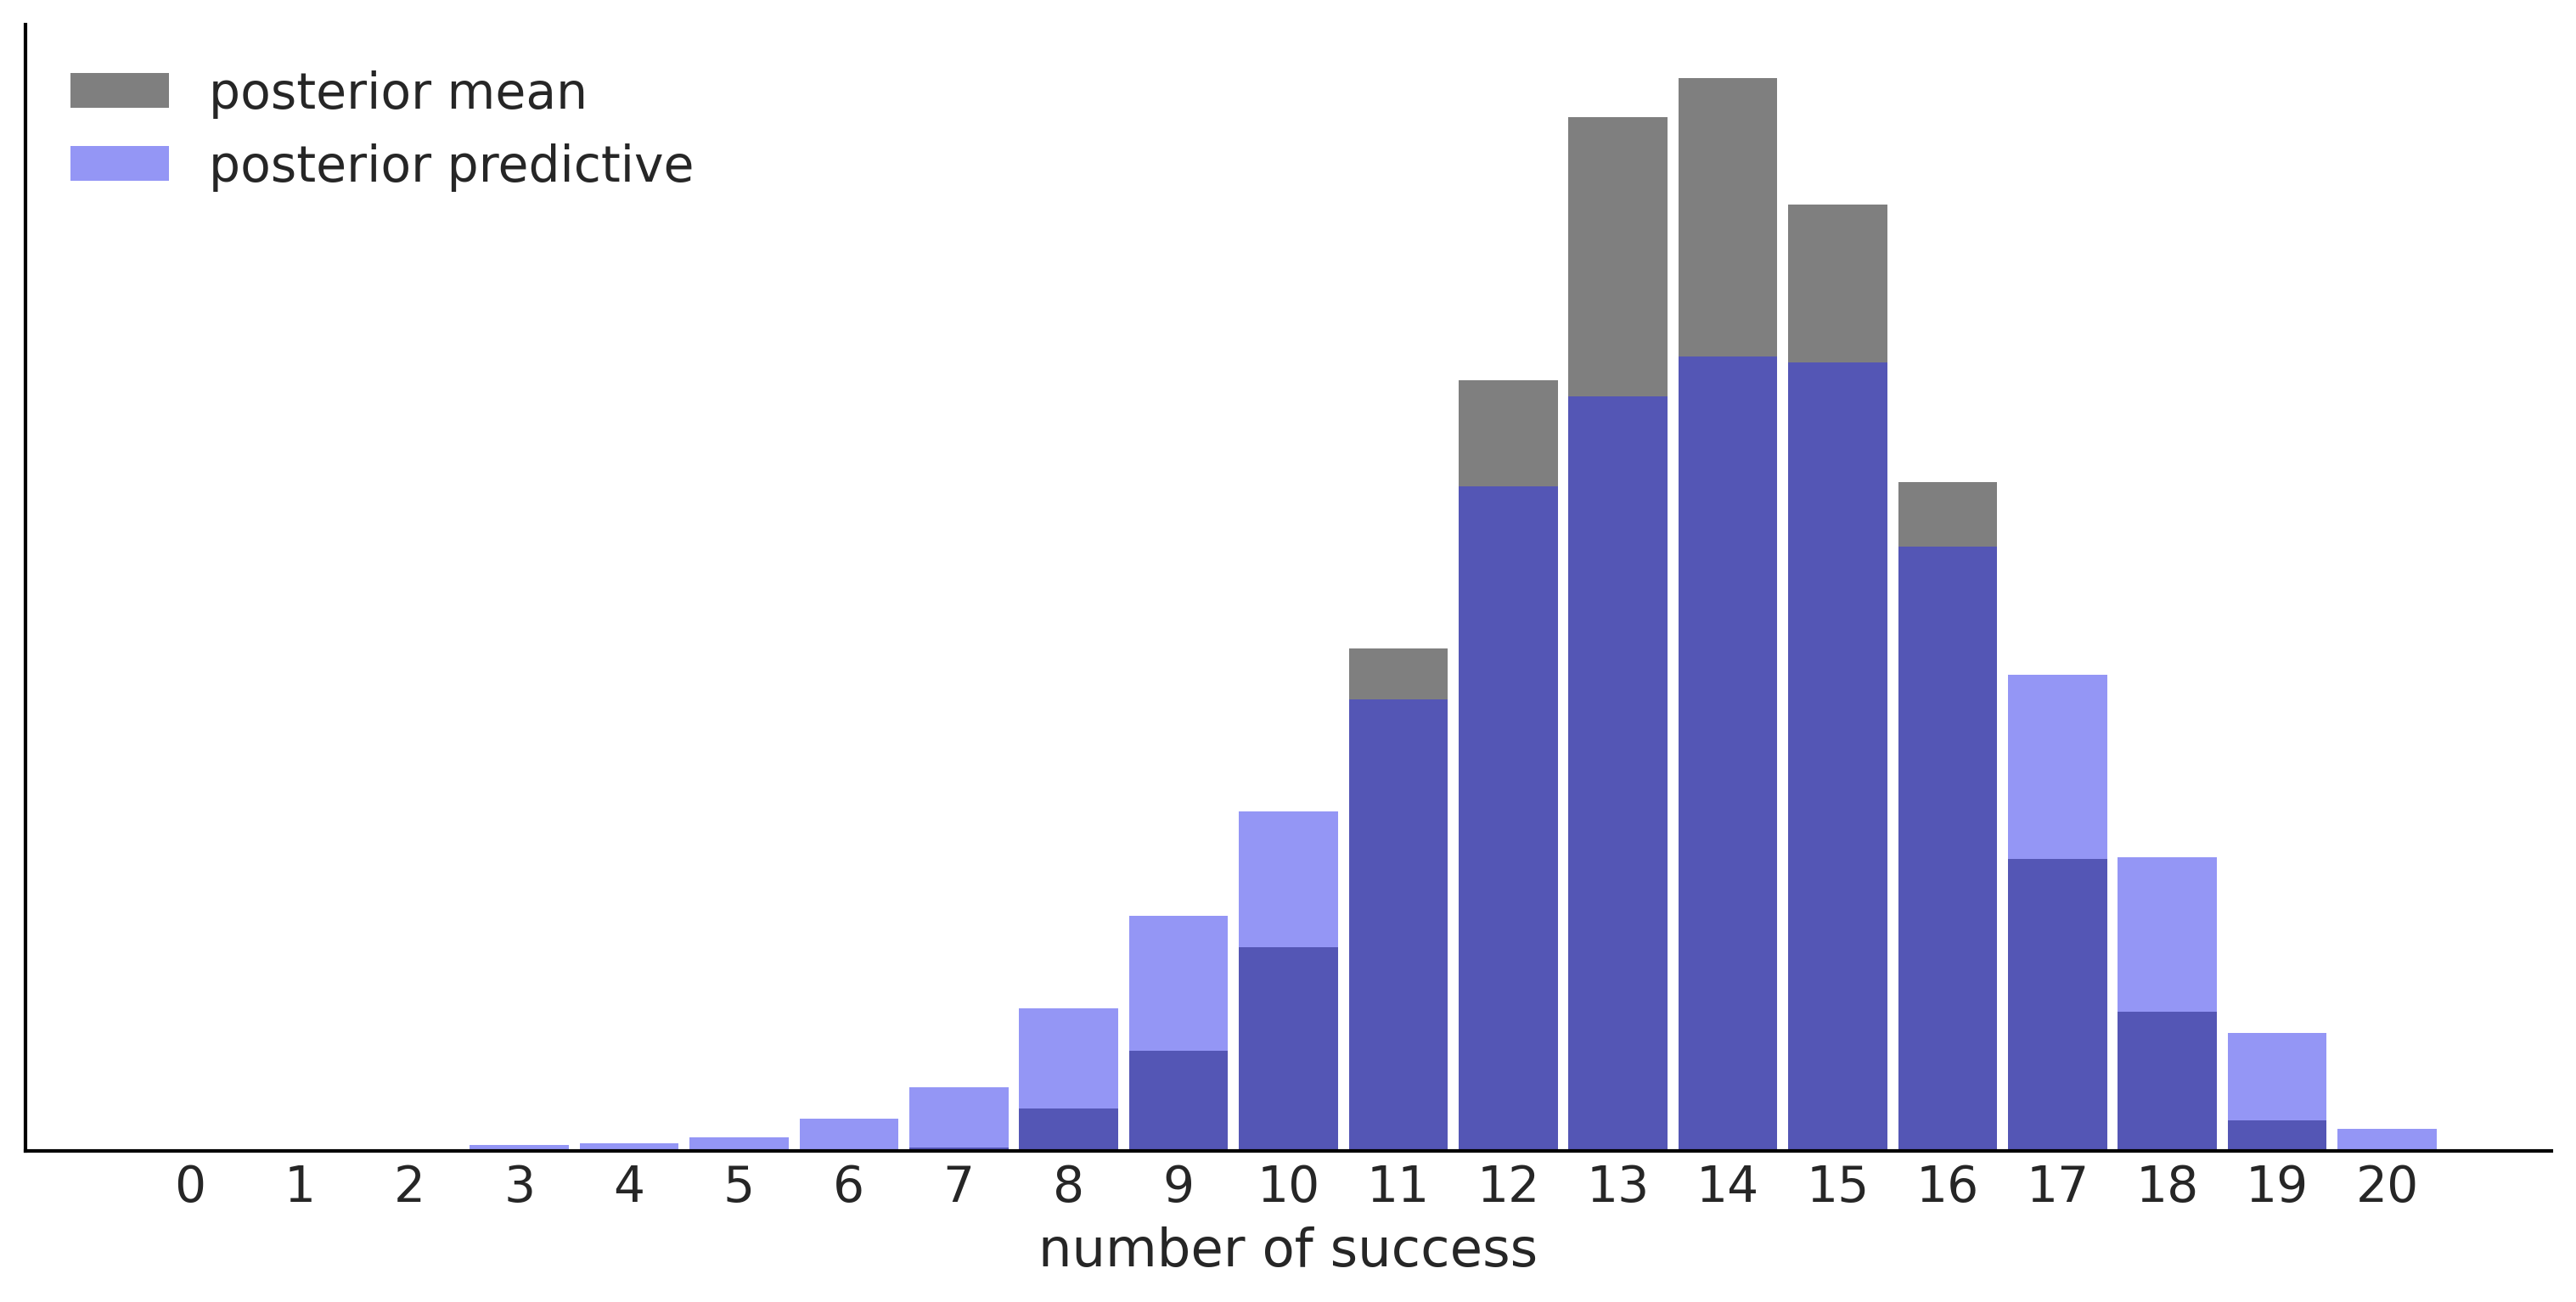

In [15]:
predictions = (stats.binom(n=1, p=idata.posterior["θ"].mean()).rvs((4000, len(Y))),
               pred_dists[1])

for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(-1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")
plt.savefig("img/chp01/predictions_distributions.png")

### Code 1.8 and Figure 1.7

/tmp/ipykernel_20488/681309949.py:19: RuntimeWarning: invalid value encountered in divide
  axes[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)


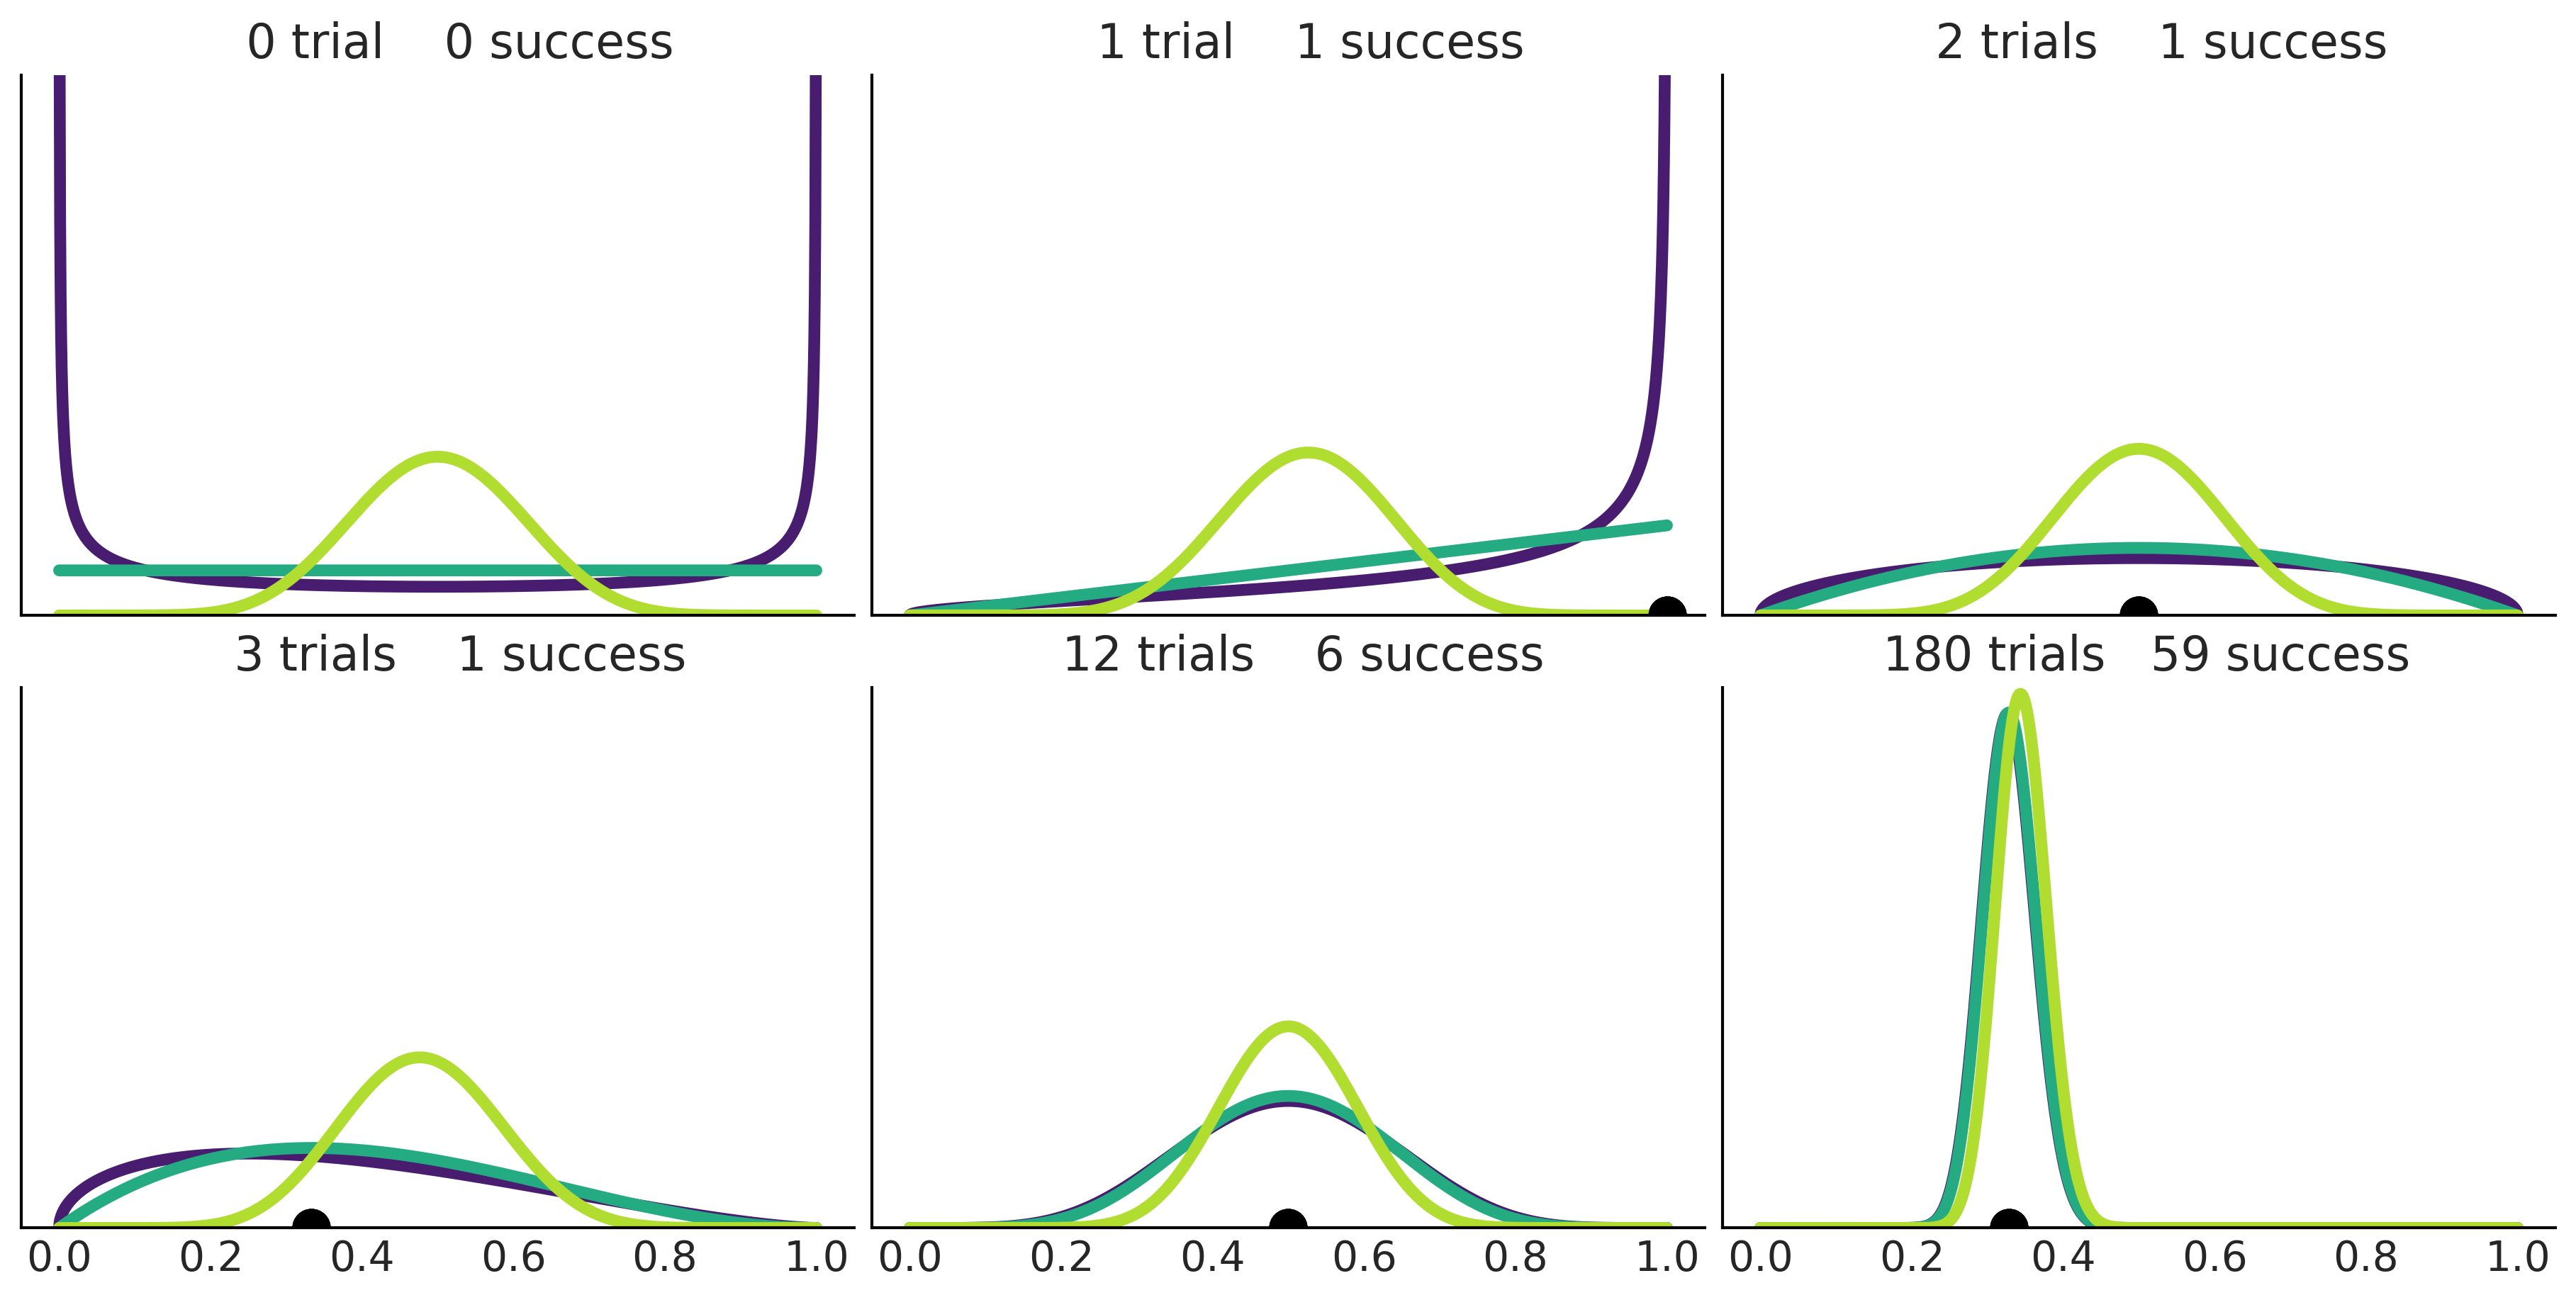

In [16]:
_, axes = plt.subplots(2,3, figsize=(12, 6), sharey=True, sharex=True,
                     constrained_layout=True)
axes = np.ravel(axes)

n_trials = [0, 1, 2, 3, 12, 180]
success = [0, 1, 1, 1, 6, 59]
data = zip(n_trials, success)

beta_params = [(0.5, 0.5), (1, 1), (10, 10)]
θ = np.linspace(0, 1, 1500)
for idx, (N, y) in enumerate(data):
    s_n = ('s' if (N > 1) else '')
    for jdx, (a_prior, b_prior) in enumerate(beta_params):
        p_theta_given_y = stats.beta.pdf(θ, a_prior + y, b_prior + N - y)

        axes[idx].plot(θ, p_theta_given_y, lw=4, color=viridish[jdx])
        axes[idx].set_yticks([])
        axes[idx].set_ylim(0, 12)
        axes[idx].plot(np.divide(y, N), 0, color='k', marker='o', ms=12)
        axes[idx].set_title(f'{N:4d} trial{s_n} {y:4d} success')

plt.savefig('img/chp01/beta_binomial_update.png')

### Figure 1.8

/tmp/ipykernel_20488/1383262846.py:2: RuntimeWarning: divide by zero encountered in divide
  κ = (θ / (1-θ))
/tmp/ipykernel_20488/1383262846.py:10: RuntimeWarning: divide by zero encountered in power
  axes[0, 0].plot(θ, θ**(-0.5) * (1-θ)**(-0.5))
/tmp/ipykernel_20488/1383262846.py:15: RuntimeWarning: divide by zero encountered in power
  axes[0, 1].plot(κ, κ**(-0.5) * (1 + κ)**(-1))
/tmp/ipykernel_20488/1383262846.py:17: RuntimeWarning: invalid value encountered in multiply
  axes[1, 1].plot(κ, κ**(y-0.5) * (1 + κ)**(-n-1))


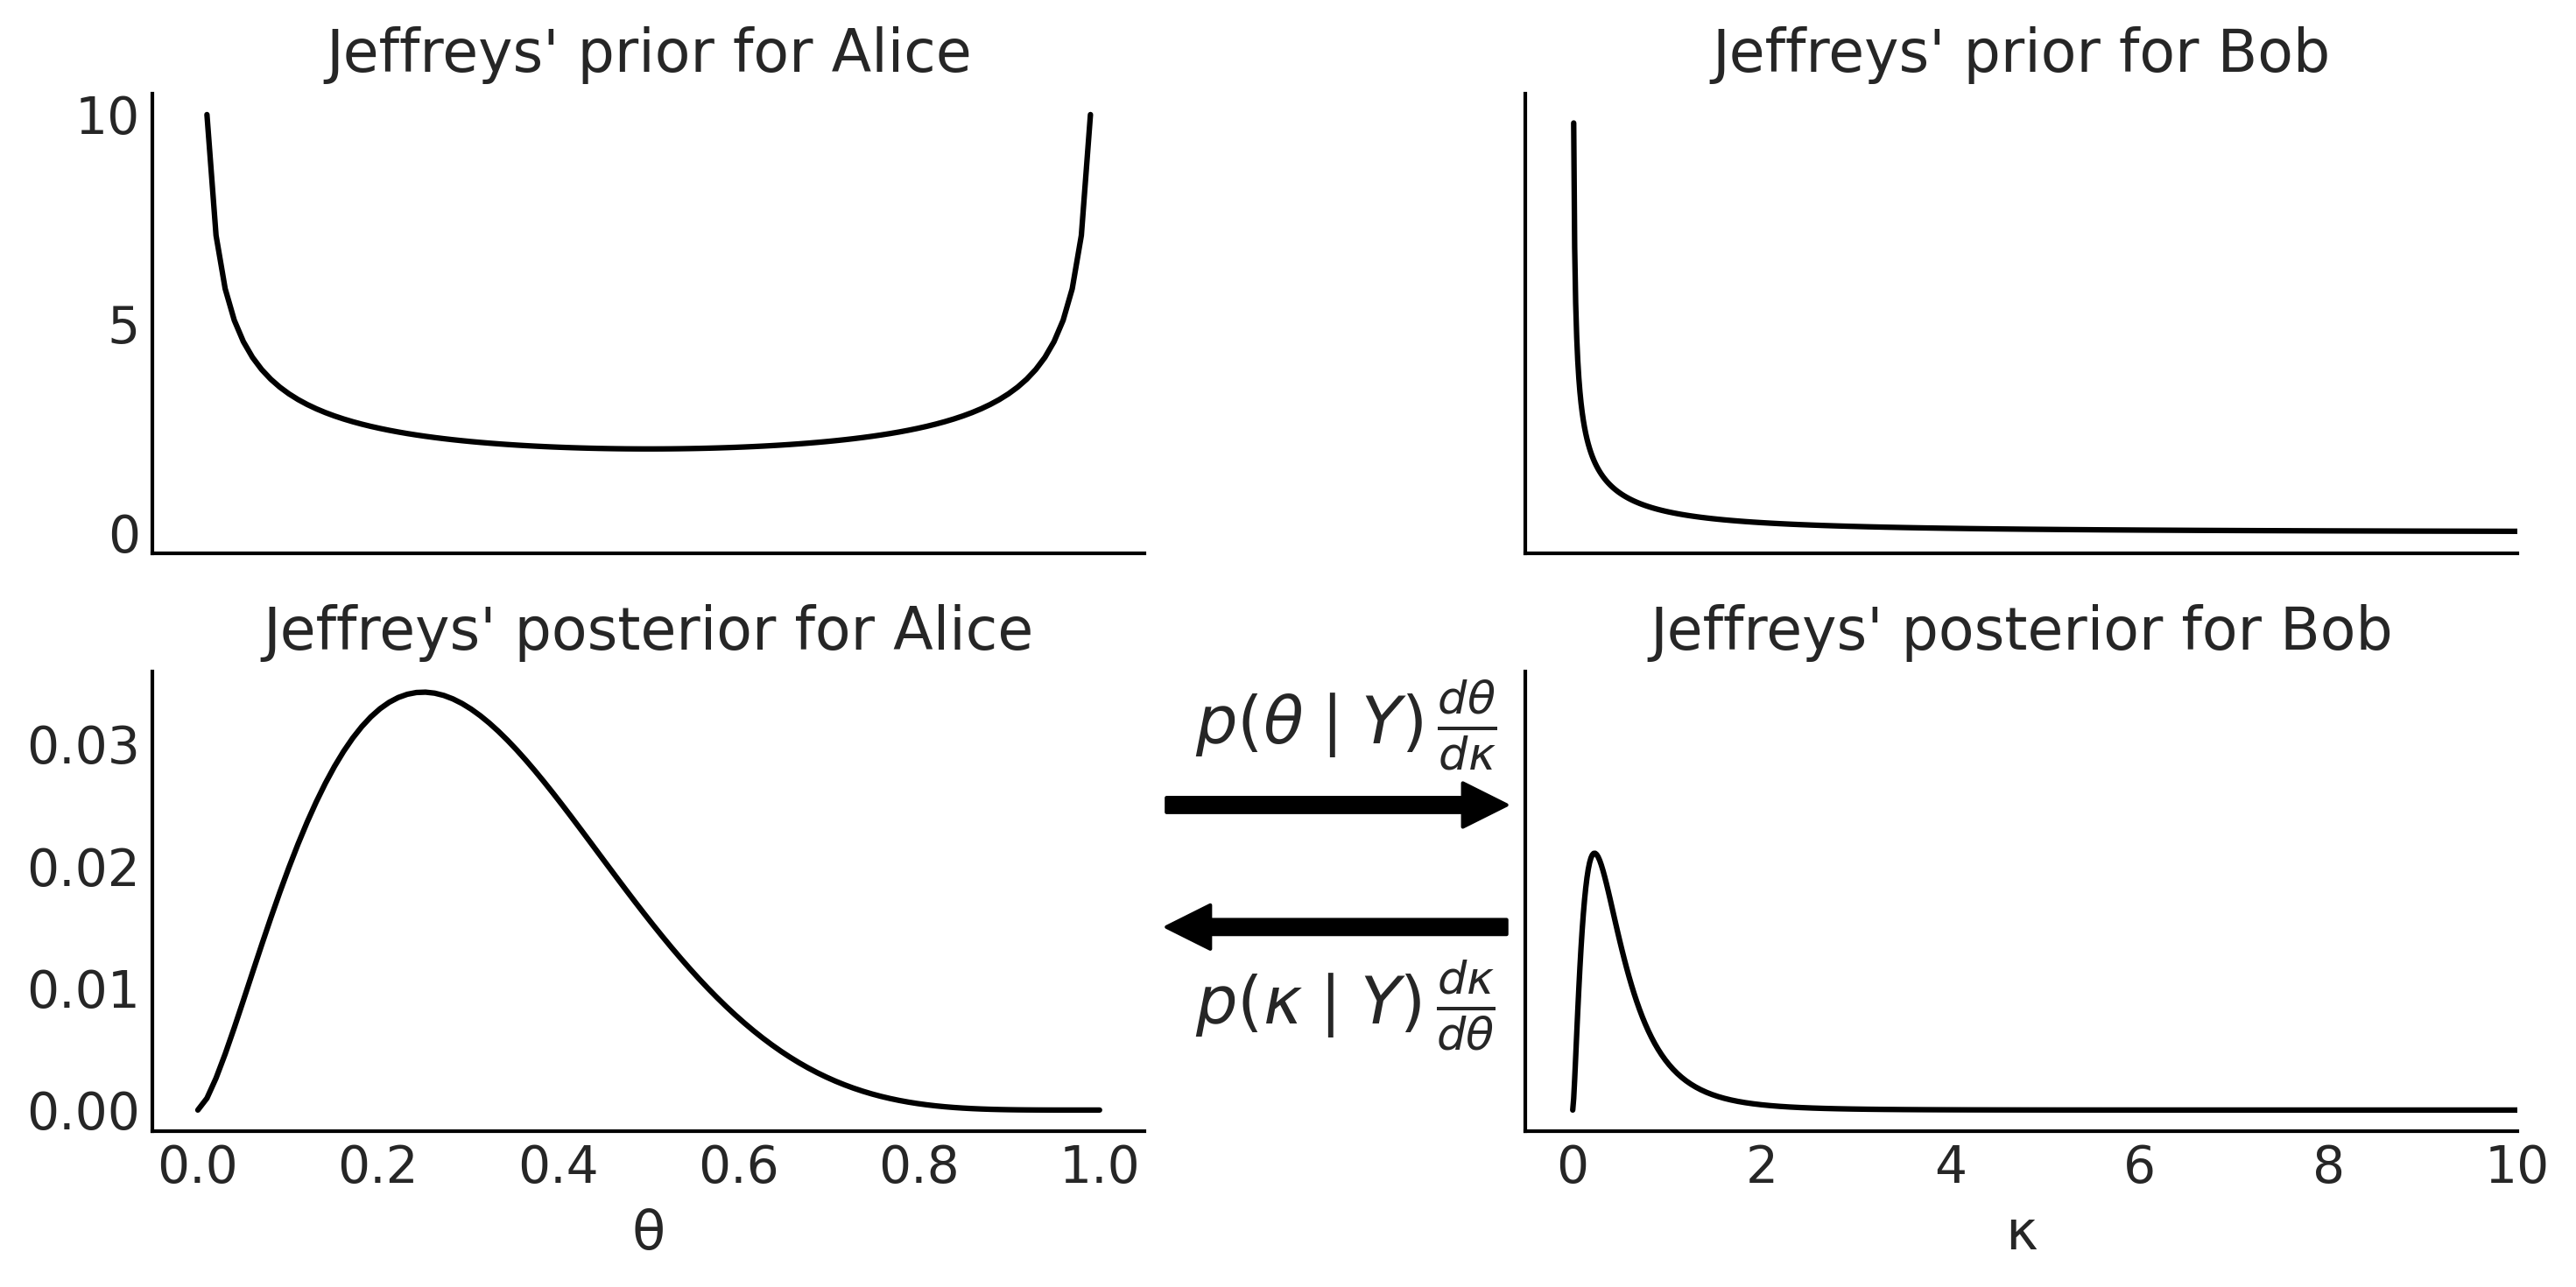

In [17]:
θ = np.linspace(0, 1, 100)
κ = (θ / (1-θ))
y = 2
n = 7

_, axes = plt.subplots(2, 2, figsize=(10, 5),
                     sharex='col', sharey='row', constrained_layout=False)

axes[0, 0].set_title("Jeffreys' prior for Alice")
axes[0, 0].plot(θ, θ**(-0.5) * (1-θ)**(-0.5))
axes[1, 0].set_title("Jeffreys' posterior for Alice")
axes[1, 0].plot(θ, θ**(y-0.5) * (1-θ)**(n-y-0.5))
axes[1, 0].set_xlabel("θ")
axes[0, 1].set_title("Jeffreys' prior for Bob")
axes[0, 1].plot(κ, κ**(-0.5) * (1 + κ)**(-1))
axes[1, 1].set_title("Jeffreys' posterior for Bob")
axes[1, 1].plot(κ, κ**(y-0.5) * (1 + κ)**(-n-1))
axes[1, 1].set_xlim(-0.5, 10)
axes[1, 1].set_xlabel("κ")
axes[1, 1].text(-4.0, 0.030, size=18, s=r'$p(\theta \mid Y) \, \frac{d\theta}{d\kappa}$')
axes[1, 1].annotate("", xy=(-0.5, 0.025), xytext=(-4.5, 0.025),
                  arrowprops=dict(facecolor='black', shrink=0.05))
axes[1, 1].text(-4.0, 0.007, size=18, s= r'$p(\kappa \mid Y) \, \frac{d\kappa}{d\theta}$')
axes[1, 1].annotate("", xy=(-4.5, 0.015), xytext=(-0.5, 0.015),
                  arrowprops=dict(facecolor='black', shrink=0.05),
                  annotation_clip=False)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout()
plt.savefig("img/chp01/Jeffrey_priors.png")

### Figure 1.9

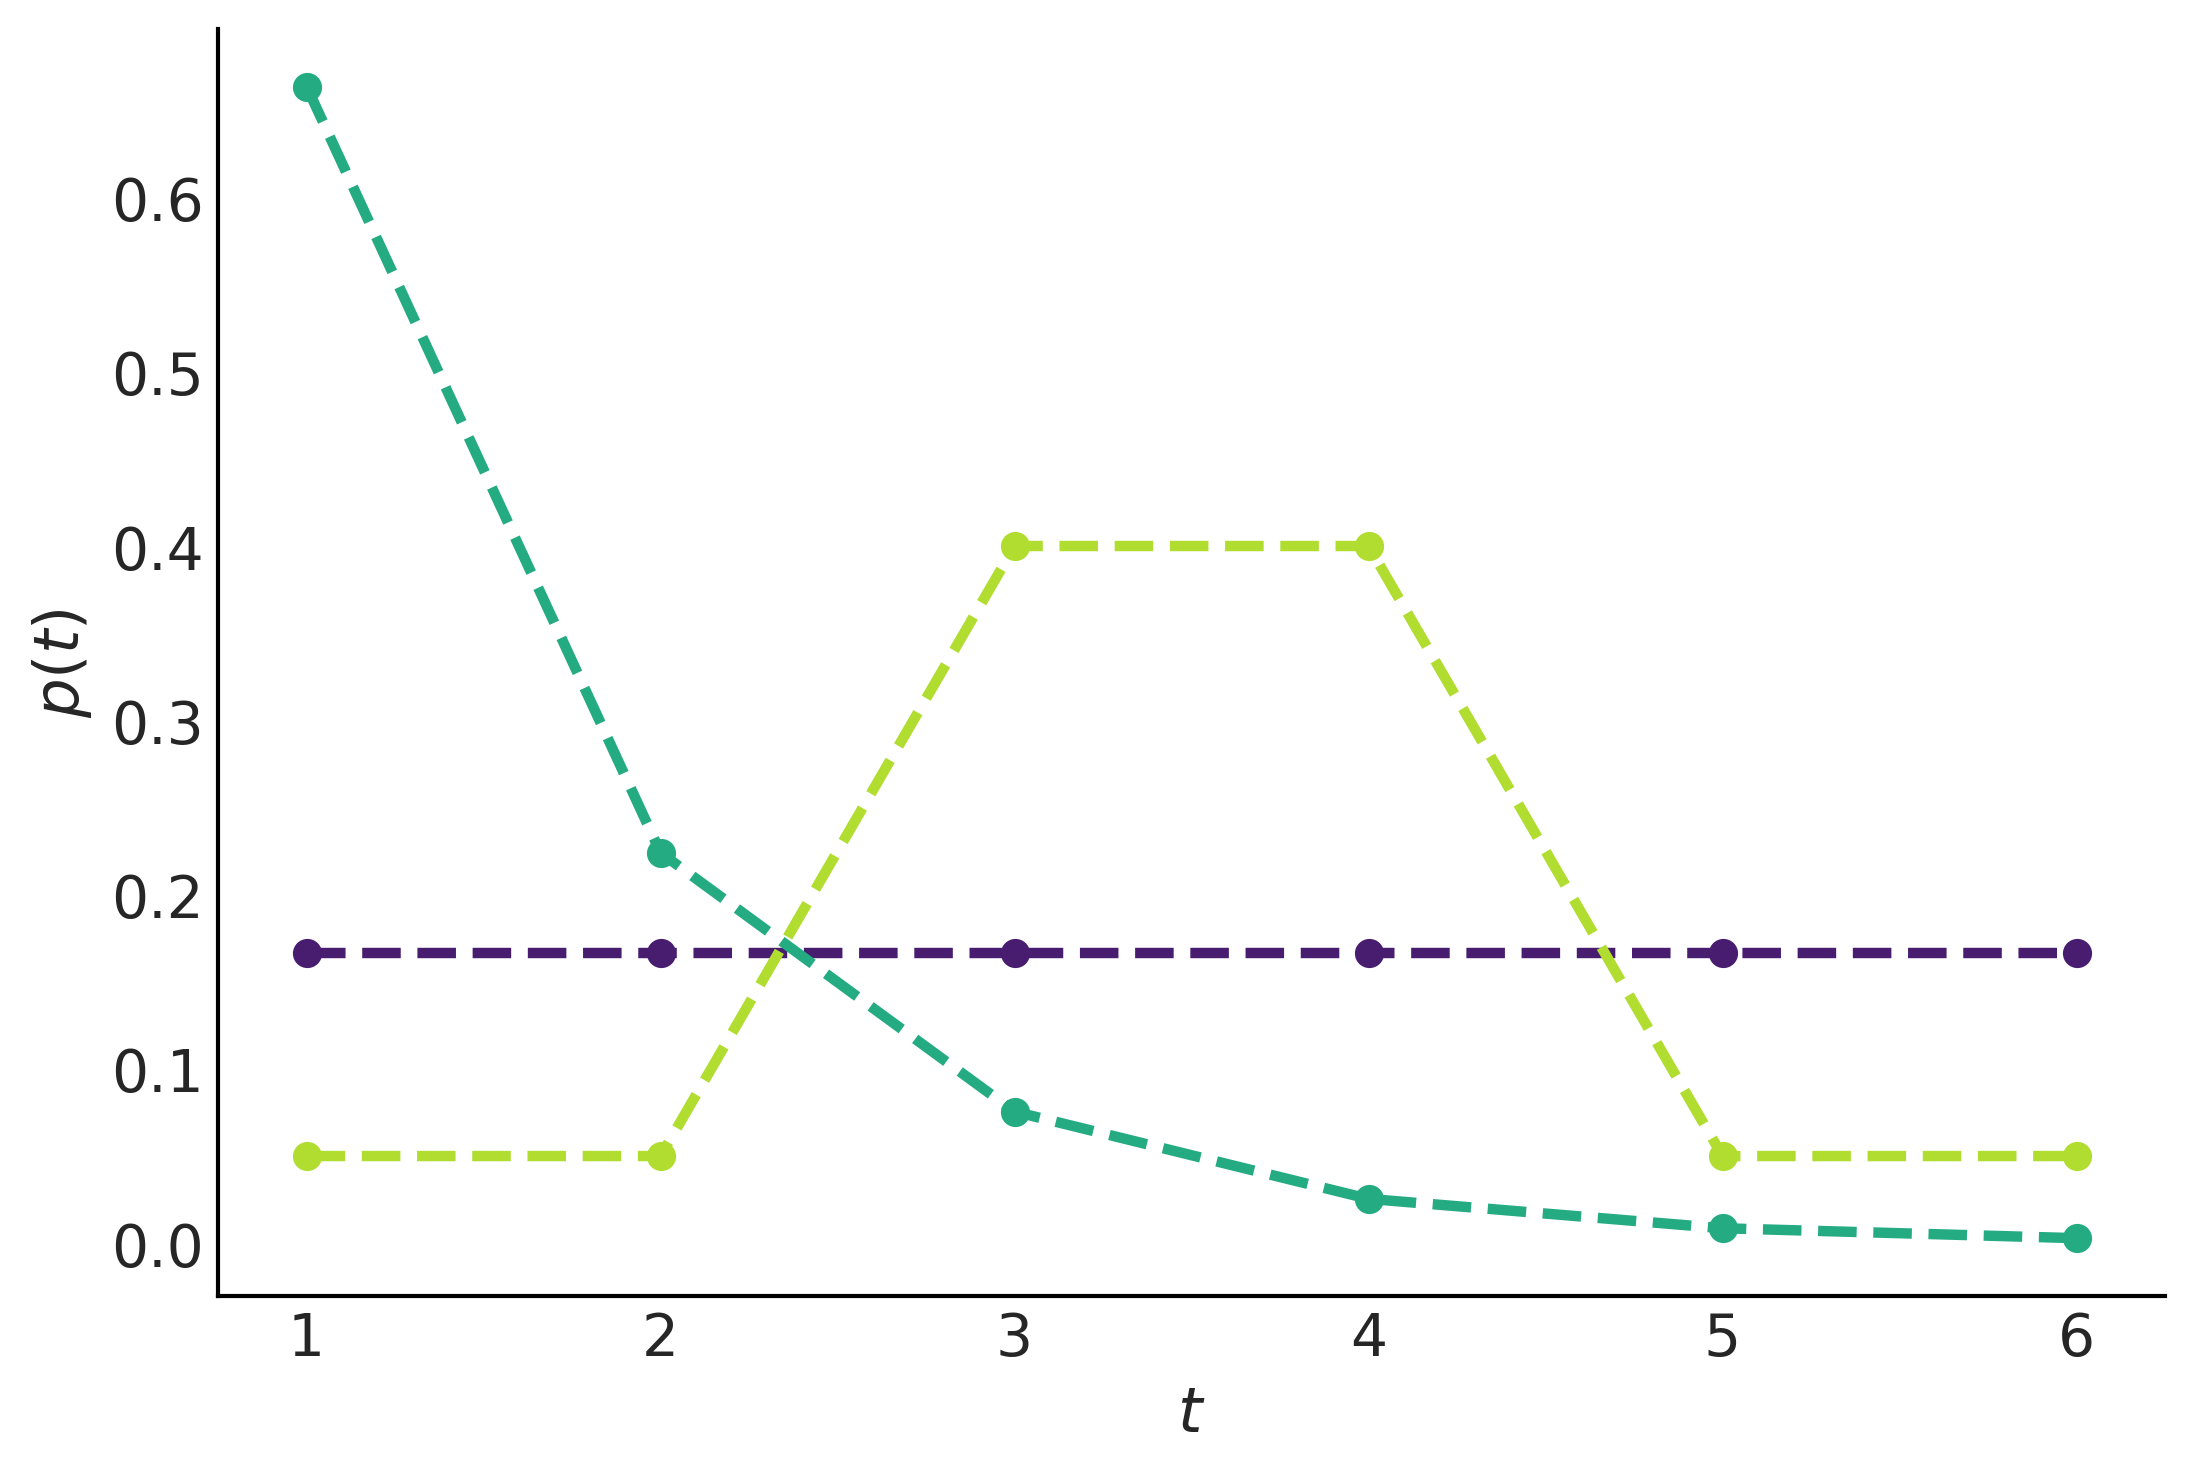

In [18]:
cons = [[{"type": "eq", "fun": lambda x: np.sum(x) - 1}],
        [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
         {"type": "eq", "fun": lambda x: 1.5 - np.sum(x * np.arange(1, 7))}],
        [{"type": "eq", "fun": lambda x: np.sum(x) - 1},
         {"type": "eq", "fun": lambda x: np.sum(x[[2, 3]]) - 0.8}]]

max_ent = []
for i, c in enumerate(cons):
    val = minimize(lambda x: -entropy(x), x0=[1/6]*6, bounds=[(0., 1.)] * 6,
                   constraints=c)['x']
    max_ent.append(entropy(val))
    plt.plot(np.arange(1, 7), val, 'o--', color=viridish[i], lw=2.5)
plt.xlabel("$t$")
plt.ylabel("$p(t)$")

plt.savefig("img/chp01/max_entropy.png")

### Code 1.10

In [19]:
ite = 100_000
entropies = np.zeros((3, ite))
for idx in range(ite):
    rnds = np.zeros(6)
    total = 0
    x_ = np.random.choice(np.arange(1, 7), size=6, replace=False)
    for i in x_[:-1]:
        rnd = np.random.uniform(0, 1-total)
        rnds[i-1] = rnd
        total = rnds.sum()
    rnds[-1] = 1 - rnds[:-1].sum()
    H = entropy(rnds)
    entropies[0, idx] = H
    if abs(1.5 - np.sum(rnds * x_)) < 0.01:
        entropies[1, idx] = H
    prob_34 = sum(rnds[np.argwhere((x_ == 3) | (x_ == 4)).ravel()])
    if abs(0.8 - prob_34) < 0.01:
        entropies[2, idx] = H

### Figure 1.10

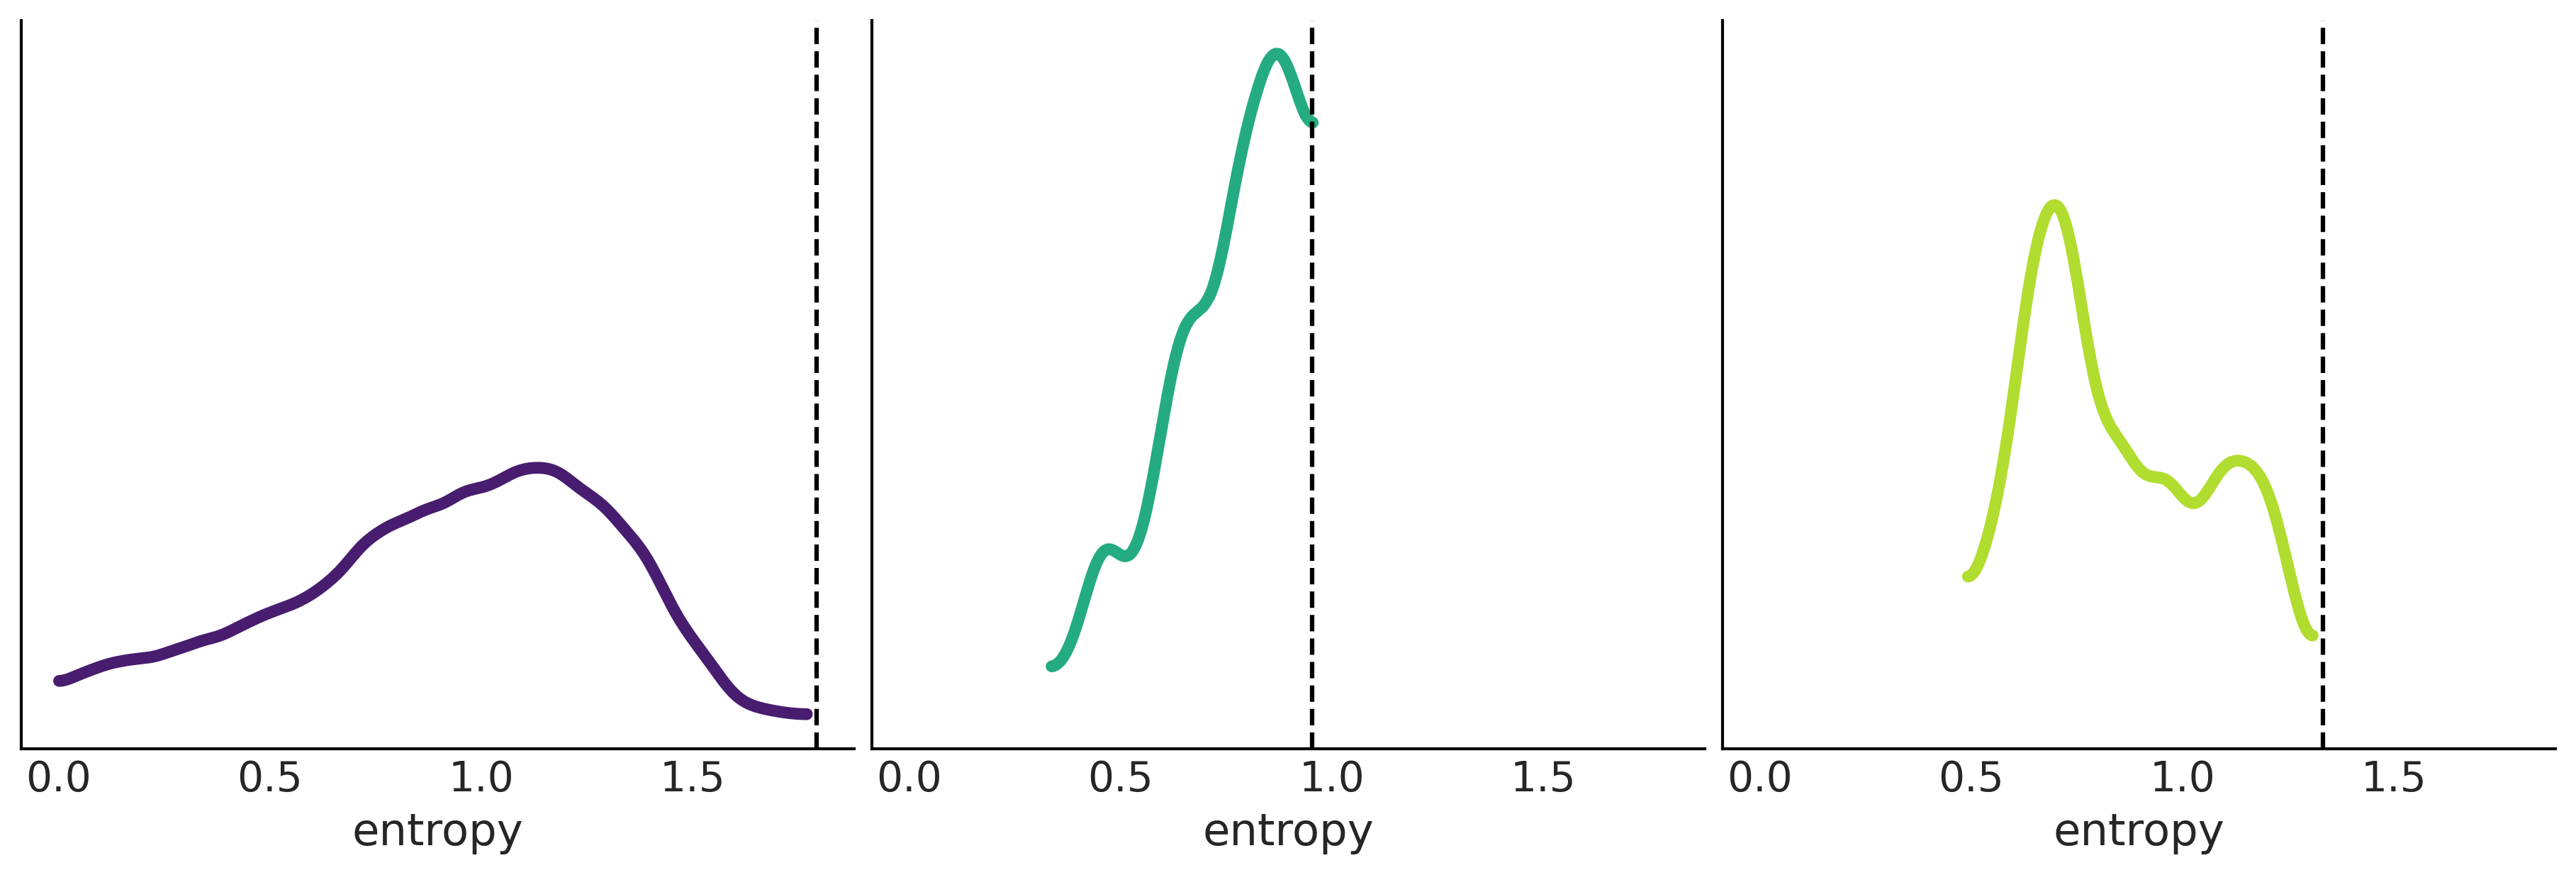

In [20]:
_, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True, constrained_layout=True)

for i in range(3):
    az.plot_kde(entropies[i][np.nonzero(entropies[i])], ax=ax[i], plot_kwargs={"color":viridish[i], "lw":4})
    ax[i].axvline(max_ent[i], 0, 1, ls="--")
    ax[i].set_yticks([])
    ax[i].set_xlabel("entropy")
plt.savefig("img/chp01/max_entropy_vs_random_dist.png")

### Figure 1.11

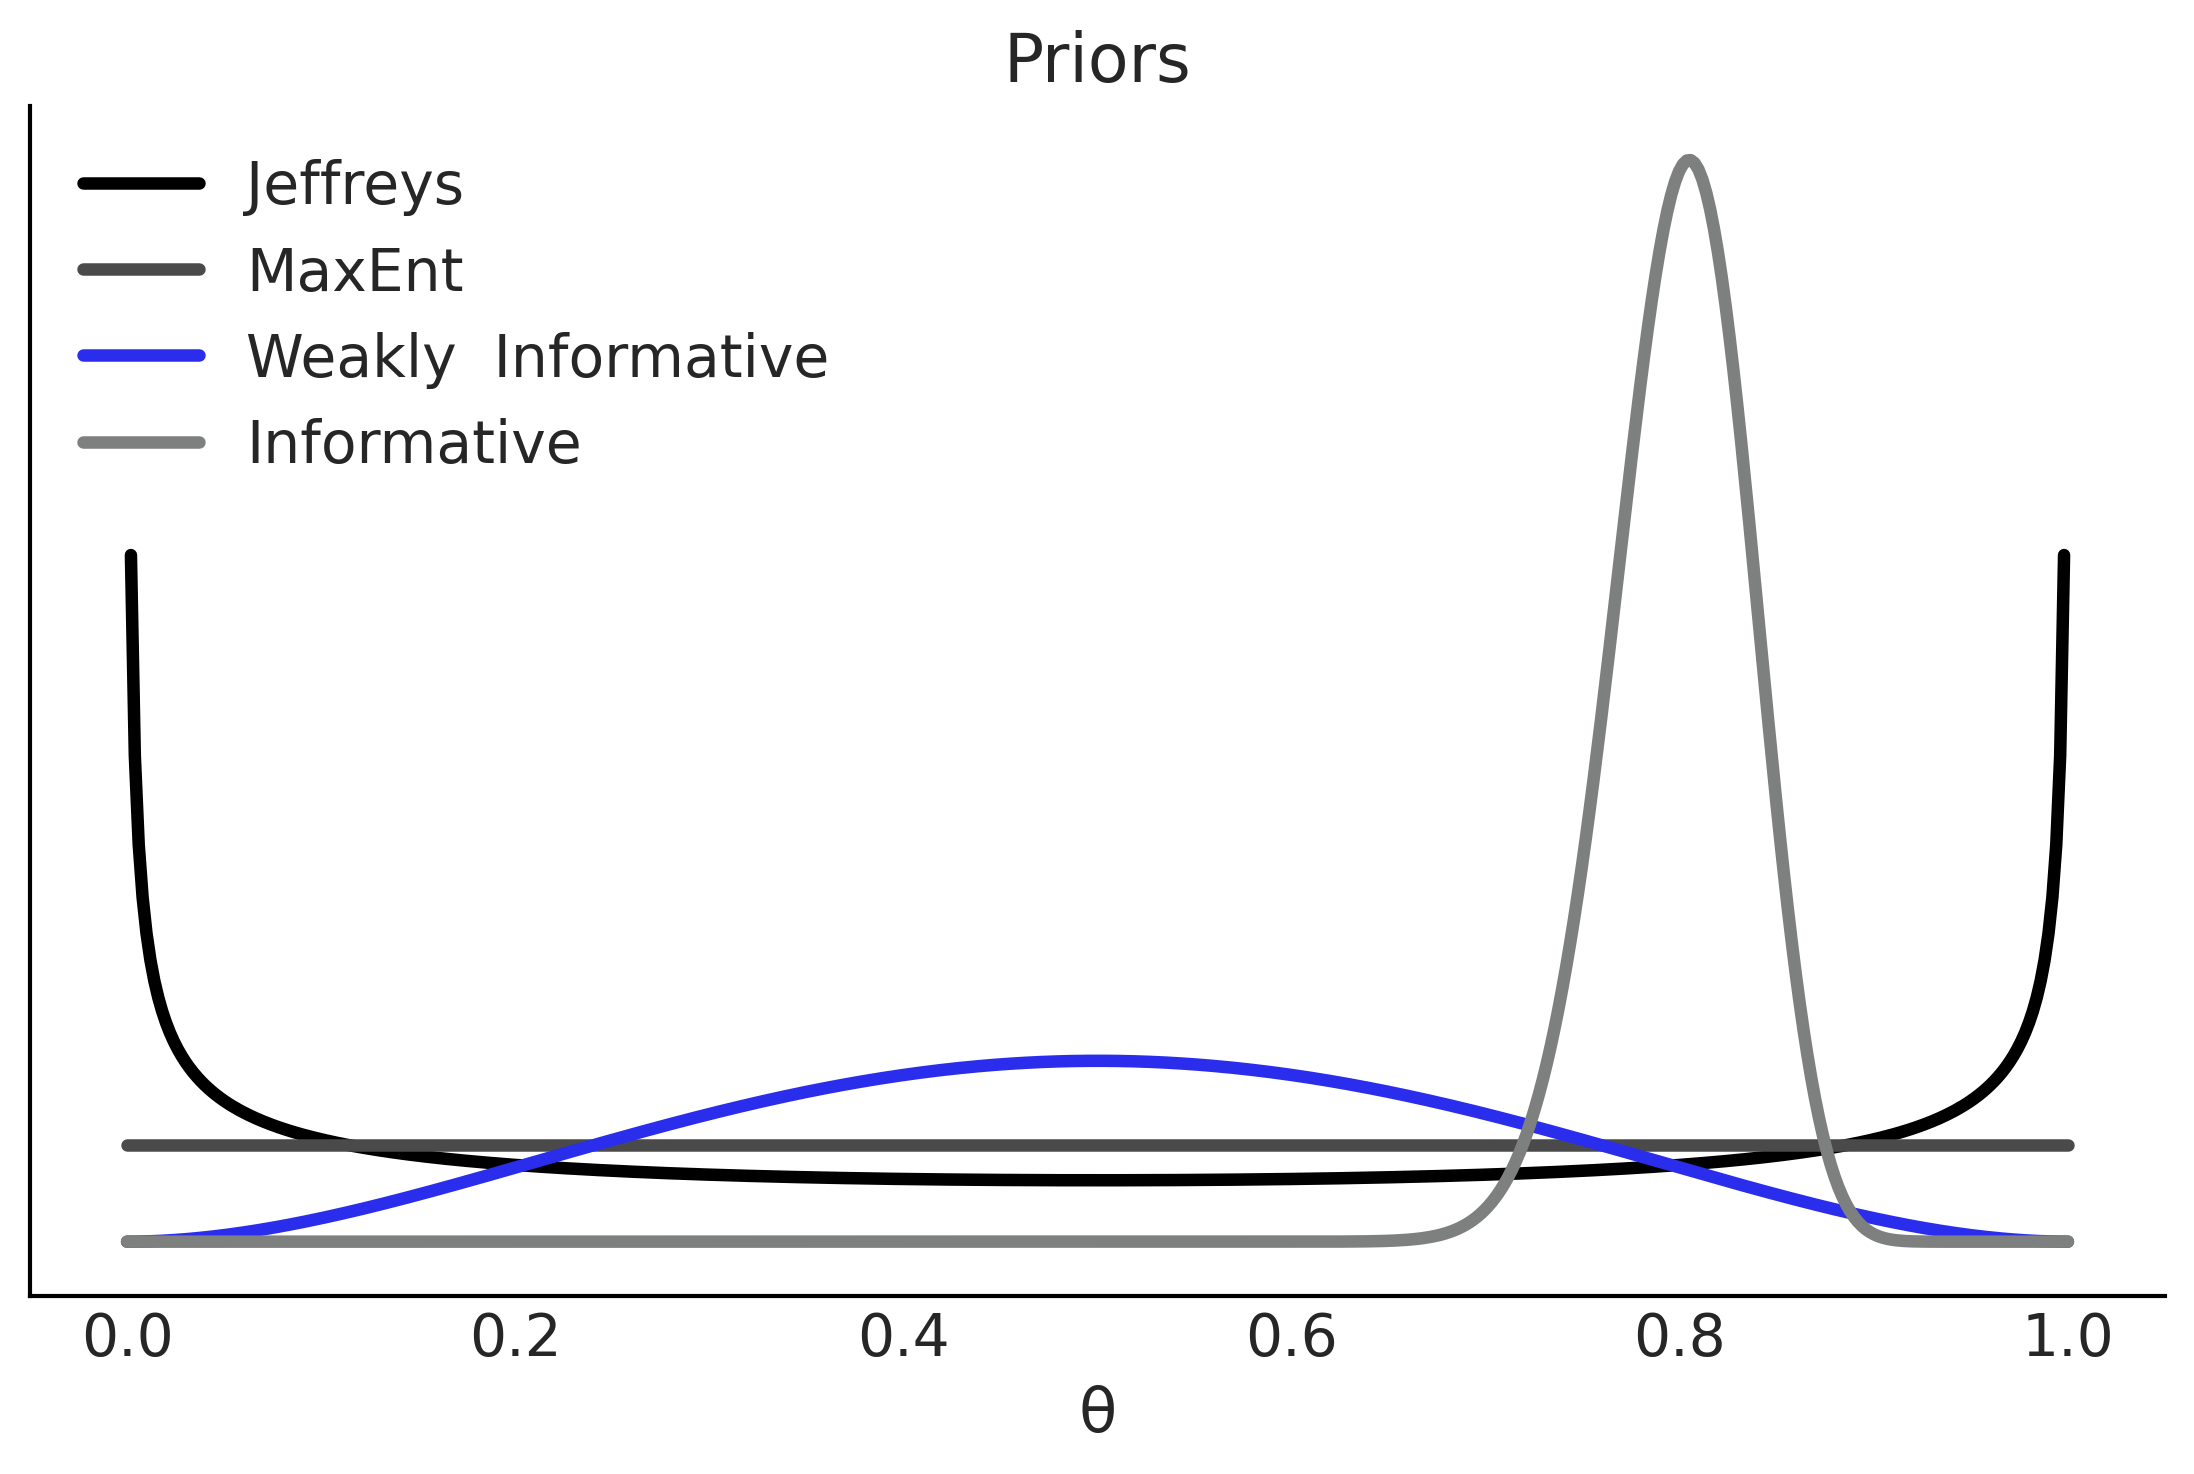

In [21]:
x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys", "MaxEnt", "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = stats.beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}", lw=3)
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
plt.savefig("img/chp01/prior_informativeness_spectrum.png")